# 国债期货策略研究

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import datetime
import statsmodels.api as sm
import scipy
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
from statsmodels import api as stm 
from statsmodels import tools
from scipy.optimize import minimize
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import prettytable as pt
from numpy import random
import gc 
import psutil
import os
plt.style.use("seaborn")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='retina'
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

## 数据预处理

### 给出高/开/低/收

In [82]:
###给出高/开/低/收
day_number = 18*3
year = [15,16,17,18,19,20,21]*4
year = sorted(year)
month = ['03','06','09','12']*7
file_name = ['T'+str(x)+y + '.CCFX.xlsx' for x,y in zip(year,month)]

def draw_data(raw_data):
    data = raw_data[['open','close','high','low','volume']]#我们只使用高开低收和成交量5个数据
    data.iloc[:,4] = data.iloc[:,4].rolling(15).sum()#价格用该时间点的价格即可，成交量要算求和,这里假设用的是15min来进行slice
    data['open'] = [0]*14+list(data.iloc[:-14,0].values)#开盘价
    data['high'] = data['high'].rolling(15).max()#最大值
    data['low'] = data['low'].rolling(15).min()#最小值
    
    data=data[data.index.minute.isin([15,30,45,0])] 
    data['open'] = data['open']/data['close']
    data['high'] = data['high']/data['close']
    data['low'] = data['low']/data['close']
    data['close'] = data['close'].pct_change()
    
    return data

def get_return_flow(future1,future2):
    #输入两个期货价格的dataframe，需注意future1是已有的序列，future2是要加入的序列
    nn = pd.concat([future1,future2],axis=1)
    #当过去1天的下一期期货成交量超过上一期的，定义为主力合约的切换
    index = nn[(nn.iloc[:,4].rolling(day_number).sum()<nn.iloc[:,9].rolling(day_number).sum()).values].index[1]
    print("合约切换时间：",index)
    result = pd.concat([future1.loc[:index].iloc[:-1],future2.loc[index:]],axis=0)
    return result

initial =1
for name in file_name:
    print("处理文件"+name)
    #print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
    try:
        file_location = './data_minute/'+name
        raw_data = pd.read_excel(file_location,index_col=0 )
    except:
        continue
        
    if initial==1:
        initial =0
        future1 = draw_data(raw_data)
        del raw_data
        gc.collect()
        continue
        
    future2 = draw_data(raw_data)
    try:
        future1 = get_return_flow(future1,future2)
    except:
        print("数据整合结束")
        break
    del future2, raw_data
    gc.collect()

future1.iloc[0,1] = 0
future_integrate = future1.loc[future1.index[1]:future1[(future1.iloc[:,4]>0).values].index[-1]]
future_price = future_integrate.copy()
future_price.iloc[:,1] = (future_price.iloc[:,1]+1).cumprod()
future_price['open'] = future_price['open']*future_price['close']
future_price['high'] = future_price['high']*future_price['close']
future_price['low'] = future_price['low']*future_price['close']
future_price.iloc[:,0:4] = future_price.iloc[:,0:4]*100

处理文件T1503.CCFX.xlsx
处理文件T1506.CCFX.xlsx
处理文件T1509.CCFX.xlsx
处理文件T1512.CCFX.xlsx
合约切换时间： 2015-08-14 11:30:00
处理文件T1603.CCFX.xlsx
合约切换时间： 2015-11-24 10:45:00
处理文件T1606.CCFX.xlsx
合约切换时间： 2016-02-18 11:15:00
处理文件T1609.CCFX.xlsx
合约切换时间： 2016-05-10 10:15:00
处理文件T1612.CCFX.xlsx
合约切换时间： 2016-08-11 14:00:00
处理文件T1703.CCFX.xlsx
合约切换时间： 2016-11-10 14:30:00
处理文件T1706.CCFX.xlsx
合约切换时间： 2017-01-25 10:15:00
处理文件T1709.CCFX.xlsx
合约切换时间： 2017-05-11 13:45:00
处理文件T1712.CCFX.xlsx
合约切换时间： 2017-08-10 10:15:00
处理文件T1803.CCFX.xlsx
合约切换时间： 2017-11-13 10:30:00
处理文件T1806.CCFX.xlsx
合约切换时间： 2018-02-12 11:00:00
处理文件T1809.CCFX.xlsx
合约切换时间： 2018-05-21 10:45:00
处理文件T1812.CCFX.xlsx
合约切换时间： 2018-08-16 13:30:00
处理文件T1903.CCFX.xlsx
合约切换时间： 2018-11-19 13:30:00
处理文件T1906.CCFX.xlsx
合约切换时间： 2019-02-21 14:15:00
处理文件T1909.CCFX.xlsx
合约切换时间： 2019-05-22 10:00:00
处理文件T1912.CCFX.xlsx
合约切换时间： 2019-08-15 13:30:00
处理文件T2003.CCFX.xlsx
合约切换时间： 2019-11-20 11:30:00
处理文件T2006.CCFX.xlsx
合约切换时间： 2020-02-19 10:15:00
处理文件T2009.CCFX.xlsx
合约切换时间： 

### 单独给出收盘价格

In [3]:
###单独给出收盘价格

day_number = 18*3
year = [15,16,17,18,19,20,21]*4
year = sorted(year)
month = ['03','06','09','12']*7
file_name = ['T'+str(x)+y + '.CCFX.xlsx' for x,y in zip(year,month)]
#print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
def draw_data(raw_data):
    data = raw_data[['close','volume']]#我们只使用收盘价和成交量两个数据
    data.iloc[:,1] = data.iloc[:,1].rolling(15).sum()#价格用该时间点的价格即可，成交量要算求和,这里假设用的是15min来进行slice
    data=data[data.index.minute.isin([15,30,45,0])] 
    data['close'] = data['close'].pct_change()
    return data

def get_return_flow(future1,future2):
    #输入两个期货价格的dataframe，需注意future1是已有的序列，future2是要加入的序列
    nn = pd.concat([future1,future2],axis=1)
    #当过去1天的下一期期货成交量超过上一期的，定义为主力合约的切换
    index = nn[(nn.iloc[:,1].rolling(day_number).sum()<nn.iloc[:,3].rolling(day_number).sum()).values].index[1]
    print("合约切换时间：",index)
    result = pd.concat([future1.loc[:index].iloc[:-1],future2.loc[index:]],axis=0)
    return result

initial =1
for name in file_name:
    print("处理文件"+name)
    #print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
    try:
        file_location = './data_minute/'+name
        raw_data = pd.read_excel(file_location,index_col=0 )
    except:
        continue
        
    if initial==1:
        initial =0
        future1 = draw_data(raw_data)
        del raw_data
        gc.collect()
        continue
        
    future2 = draw_data(raw_data)
    try:
        future1 = get_return_flow(future1,future2)
    except:
        print("数据整合结束")
        break
    del future2, raw_data
    gc.collect()
future1.iloc[0,0] = 0
future_return = future1.loc[future1.index[1]:future1[(future1.iloc[:,1]>0).values].index[-1]]
future_return.columns = ['价格变动','成交量']
future_price1 = future_return.copy()
future_price1.iloc[:,0] = (future_price1.iloc[:,0]+1).cumprod()
future_price1.columns = ['价格','成交量']

处理文件T1503.CCFX.xlsx
处理文件T1506.CCFX.xlsx
处理文件T1509.CCFX.xlsx
处理文件T1512.CCFX.xlsx
合约切换时间： 2015-08-14 11:30:00
处理文件T1603.CCFX.xlsx
合约切换时间： 2015-11-24 10:45:00
处理文件T1606.CCFX.xlsx
合约切换时间： 2016-02-18 11:15:00
处理文件T1609.CCFX.xlsx
合约切换时间： 2016-05-10 10:15:00
处理文件T1612.CCFX.xlsx
合约切换时间： 2016-08-11 14:00:00
处理文件T1703.CCFX.xlsx
合约切换时间： 2016-11-10 14:30:00
处理文件T1706.CCFX.xlsx
合约切换时间： 2017-01-25 10:15:00
处理文件T1709.CCFX.xlsx
合约切换时间： 2017-05-11 13:45:00
处理文件T1712.CCFX.xlsx
合约切换时间： 2017-08-10 10:15:00
处理文件T1803.CCFX.xlsx
合约切换时间： 2017-11-13 10:30:00
处理文件T1806.CCFX.xlsx
合约切换时间： 2018-02-12 11:00:00
处理文件T1809.CCFX.xlsx
合约切换时间： 2018-05-21 10:45:00
处理文件T1812.CCFX.xlsx
合约切换时间： 2018-08-16 13:30:00
处理文件T1903.CCFX.xlsx
合约切换时间： 2018-11-19 13:30:00
处理文件T1906.CCFX.xlsx
合约切换时间： 2019-02-21 14:15:00
处理文件T1909.CCFX.xlsx
合约切换时间： 2019-05-22 10:00:00
处理文件T1912.CCFX.xlsx
合约切换时间： 2019-08-15 13:30:00
处理文件T2003.CCFX.xlsx
合约切换时间： 2019-11-20 11:30:00
处理文件T2006.CCFX.xlsx
合约切换时间： 2020-02-19 10:15:00
处理文件T2009.CCFX.xlsx
合约切换时间： 

## 统计分析

### 统计缺口策略

In [12]:
gap = pd.DataFrame((future_price.iloc[1:,0].values-future_price.iloc[:-1,1].values),index = future_price.index[1:])
box = []
for i in range(1,100):
    box.append(np.percentile(gap,i))

In [13]:
box

[-0.07645656777991333,
 -0.03864345935894164,
 -0.01685868526727589,
 -0.01102138616502657,
 -0.010325898545048773,
 -0.005657289915987462,
 -0.005611948271578626,
 -0.005571093950678119,
 -0.005542324211802452,
 -0.00552264565764915,
 -0.005479490311174118,
 -0.005448461669971039,
 -0.005447058295331431,
 -0.005440803914751768,
 -0.005439039329743878,
 -0.005438152963392895,
 -0.005432467060003887,
 -0.005402273907264998,
 -0.005272889547839554,
 -0.005248289807738615,
 -0.005196851345445452,
 -0.0051629492725311366,
 -0.005152514427010146,
 -2.842170943040401e-14,
 -2.842170943040401e-14,
 -2.842170943040401e-14,
 -2.842170943040401e-14,
 -1.4210854715202004e-14,
 -1.4210854715202004e-14,
 -1.4210854715202004e-14,
 -1.4210854715202004e-14,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.4210854715202004e-14,
 

In [499]:
long_return = []
short_return = []
c=datetime.date(2020, 7, 6)
long =0
short = 0
for i in range(1,len(future_price)-36):
    if future_price.index[i]<c:
        morning = 8
        afternoon = 17
    if future_price.index[i]>=c:
        morning = 7
        afternoon = 16
        
    if ((future_price['open'][i] - future_price['close'][i-1])>0.005) and (future_price['open'][i]<future_price['close'][i]) :
        if (future_price['low'][i:i+morning].min()>future_price['high'][i-1]):
            if future_price['open'].pct_change(6)[i+morning]>0:#上午最后15min开盘买入，下午收盘卖出
                long = (future_price['open'].pct_change(60)[i+morning]>0.00182)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+long]+future_price['close'][i+afternoon+long])/2
                long_return.append(sell_price/buy_price-1)
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.005) and (future_price['open'][i]>future_price['close'][i]) :
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
            if future_price['open'].pct_change(3)[i+morning]<0:
                short = (future_price['open'].pct_change(60)[i+morning]<-0.00127)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+short*morning+1]+future_price['close'][i+afternoon+short*morning+1])/2
                short_return.append(1-sell_price/buy_price)


long_return = np.array(long_return)
print("做多个数:",len(long_return))
print("做多胜率:",sum(np.array(long_return)>0)/len(long_return))
print("做多赔率:",-long_return[(np.array(long_return)>0)].mean()/long_return[(np.array(long_return)<0)].mean())

short_return = np.array(short_return)
print("做空个数:",len(short_return))
print("做空胜率:",sum(np.array(short_return)>0)/len(short_return))
print("做空赔率:",-short_return[(np.array(short_return)>0)].mean()/short_return[(np.array(short_return)<0)].mean())

做多个数: 105
做多胜率: 0.5904761904761905
做多赔率: 1.0833422709006473
做空个数: 76
做空胜率: 0.5921052631578947
做空赔率: 1.91021592258511


## 回测框架

In [163]:
class back_test():
    # 输入的信号应该是时间点，当天仓位的大小
    # 价格应该是所有时间点的价格数据
    #输入数据格式都是dataframe格式
    def __init__(self,position, price,frequency):
        
        self.asset_price = price
        self.asset_price.columns = [0]
        self.position = pd.DataFrame(position.values,index = position.index) 
        self.asset_return = price.pct_change()
        self.asset_return.iloc[0] = 0
        self.frequency = frequency
        
    def calculate_net_value(self):
        self.each_return = pd.DataFrame(self.position.values*self.asset_return.values, index = self.position.index)
        self.net_value = (self.each_return+1).cumprod()
    
    def drawdown(self):
        self.withdraw = (self.net_value-self.net_value.cummax())/self.net_value.cummax()
        self.max_withdraw = (self.withdraw).min().values[0]
        
    def win_and_odd(self):
        
        #用operation来记录是否清仓，如果清仓则计入一次操作，可以用来计算胜率等指标，如果是则计1
        self.operation = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        #long_short用来判断清仓前的这次操作是多/空操作，多的话计1，空计-1
        self.long_short = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        #当仓位变成0的时候需要记下清仓,同时需要判断本次是否是否相比上个时间点是否调仓了
        #虽然这里的仓位0表示的是上一个交易时点结束时或者本次交易时间点开始时清仓，所以需要向上错一位
        self.operation[((self.position == 0).values)*((self.position.diff().abs()>0).values)] = 1 
        copy = pd.DataFrame(np.append(self.operation.iloc[1:].values, self.position.iloc[-1].abs()>0),index = self.operation.index)
        self.operation = copy
        
        #如果多翻空或者空翻多,认为中间发生了清仓，记一次操作,这里的记时指的是该交易时间点结束时清仓
        change_position = np.append((self.position.values[:-1]*self.position.values[1:]<0),[self.position.iloc[-1].abs()>0])
        self.operation[change_position] = 1 
        
        #用来记录每次操作是盈利/亏损
        self.each_operation_return = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        self.each_operation_return[(self.operation>0).values] = self.net_value[(self.operation>0).values].pct_change()#每次操作的收益
        self.each_operation_return.loc[self.each_operation_return[(self.operation>0).values].index[0]] = self.net_value[(self.operation>0).values].values[0,0]-1
        #如果是多空切换
        self.long_short[(self.operation>0).values] = (self.position[(self.operation>0).values] > 0 )*1+( self.position[(self.operation>0).values] < 0 )*(-1)#如果是多翻空的情况
#         #如果是清仓的情况
#         long_short[(self.position == 0).values*(self.position.diff()>0).values] = -1
#         long_short[(self.position == 0).values*(self.position.diff()<0).values] = 1  
        
        #计算总的胜率和赔率
        self.all_number = len(self.operation[(self.operation.abs()>0).values])
        self.win_number = len(self.each_operation_return[(self.each_operation_return>0).values])
        self.win_rate = self.win_number/self.all_number
        
        self.win_part = self.each_operation_return[ (self.each_operation_return>0).values ].mean().values[0]
        self.lost_part = -self.each_operation_return[(self.each_operation_return<0).values].mean().values[0]
        self.odds_rate = self.win_part/self.lost_part
        
        #计算做多胜率和赔率
        self.long_operation_return = self.each_operation_return[(self.long_short>0).values]
        self.long_all_number = len(self.long_operation_return)
        self.long_win_number = len(self.long_operation_return[(self.long_operation_return>0).values])
        try:
            self.long_win_rate = self.long_win_number/self.long_all_number
        except:
            self.long_win_rate = 0
        self.long_win_part = self.long_operation_return[(self.long_operation_return>0).values].mean().values[0]
        self.long_lost_part = -self.long_operation_return[(self.long_operation_return<0).values].mean().values[0]
        try:
            self.long_odds_rate = self.long_win_part/self.long_lost_part
        except:
            self.long_odds_rate =0
        
        #计算做空胜率和赔率
        self.short_operation_return = self.each_operation_return[(self.long_short<0).values]
        self.short_all_number = len(self.short_operation_return)
        self.short_win_number = len(self.short_operation_return[(self.short_operation_return>0).values])
        try:
            self.short_win_rate = self.short_win_number/self.short_all_number
        except:
            self.short_win_rate=0
            
        self.short_win_part = self.short_operation_return[(self.short_operation_return>0).values].mean().values[0]
        self.short_lost_part = -self.short_operation_return[(self.short_operation_return<0).values].mean().values[0]
        try:
            self.short_odds_rate = self.short_win_part/self.short_lost_part
        except:
            self.short_odds_rate=0

        
    #计算年化回报、年化波动率和夏普比
    def sharpe_ratio(self,frequency):
        self.annual_return = self.net_value.values[-1,0]**(frequency/len(self.net_value))-1
        self.annual_std = self.each_return.values.std()*np.sqrt(frequency)
        self.sharpe = self.annual_return/self.annual_std
    
    def show_result(self):
        self.calculate_net_value()
        self.sharpe_ratio(250*self.frequency)
        self.drawdown()
        self.win_and_odd()
        tb = pt.PrettyTable()
        tb.field_names = ["   ","回测结果展示"]
        tb.add_row(["年化收益率",round(self.annual_return,4)])
        tb.add_row(["年化波动率",round(self.annual_std,4)])
        tb.add_row(["夏普比",round(self.sharpe,4)])
        tb.add_row(["开仓次数",self.all_number])
        tb.add_row(["胜率",round(self.win_rate,4)])
        tb.add_row(["赔率",round(self.odds_rate,4)])
        
        tb.add_row(["做多次数",self.long_all_number])
        tb.add_row(["做多胜率",round(self.long_win_rate,4)])
        tb.add_row(["做多赔率",round(self.long_odds_rate,4)])
        
        tb.add_row(["做空次数",self.short_all_number])
        tb.add_row(["做空胜率",round(self.short_win_rate,4)])
        tb.add_row(["做空赔率",round(self.short_odds_rate,4)])
        tb.add_row(["最大回撤",self.max_withdraw.round(4)])
        
        tb.add_row(["回测开始时间",str(self.position.index[0])])
        tb.add_row(["回测结束时间",str(self.position.index[-1])])
        
        print(tb)
        
    def result_plot(self):
        cc= self.net_value.copy()
        res = pd.concat([cc,self.asset_price/self.asset_price.iloc[0]],axis=1).dropna()
        res.columns = ["净值",'裸多净值']
        res.iloc[:,:2].plot(legend=True,figsize=(15,10),title='曲线')
        self.out = res

## 信号产生

In [83]:
t=future_price.copy()

In [160]:
all_data

,close,volume,价格均线,成交量均线,回报,趋势,价格标准差均线,方向
2015-04-08 15:15:00,98.062655,85.0,99.091841,73.761111,-0.000420,0,0.104364,-0.082440
2015-04-09 09:30:00,98.237840,305.0,99.082824,184.000000,0.001786,0,0.103369,0.030915
2015-04-09 09:45:00,98.186315,183.0,99.073492,74.588889,-0.000524,0,0.102389,-0.041220
2015-04-09 10:00:00,98.155400,121.0,99.063731,74.383333,-0.000315,0,0.101420,-0.025763
2015-04-09 10:15:00,98.103875,90.0,99.053369,74.566667,-0.000525,0,0.100446,-0.056678
...,...,...,...,...,...,...,...,...
2020-07-03 10:45:00,112.289473,2248.0,112.389334,3136.738889,-0.000150,0,0.133780,-0.011224
2020-07-03 11:00:00,112.300697,2838.0,112.388243,3122.061111,0.000100,0,0.134326,0.011224
2020-07-03 11:15:00,112.368040,3239.0,112.388025,3109.438889,0.000600,0,0.134868,0.067343
2020-07-03 11:30:00,112.339981,2742.0,112.387495,3109.722222,-0.000250,0,0.135402,-0.028060


In [188]:
all_data[['volume','成交量均线']]

,volume,成交量均线
2015-04-08 15:15:00,85.0,73.761111
2015-04-09 09:30:00,305.0,184.000000
2015-04-09 09:45:00,183.0,74.588889
2015-04-09 10:00:00,121.0,74.383333
2015-04-09 10:15:00,90.0,74.566667
...,...,...
2020-07-03 10:45:00,2248.0,3136.738889
2020-07-03 11:00:00,2838.0,3122.061111
2020-07-03 11:15:00,3239.0,3109.438889
2020-07-03 11:30:00,2742.0,3109.722222


In [217]:
up_back.values[:,0]

array([False, False, False, ...,  True,  True,  True])

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        0.0198       |
|  年化波动率  |        0.0242       |
|    夏普比    |        0.8157       |
|   开仓次数   |         144         |
|     胜率     |        0.375        |
|     赔率     |        2.405        |
|   做多次数   |          75         |
|   做多胜率   |        0.4533       |
|   做多赔率   |        2.8311       |
|   做空次数   |          69         |
|   做空胜率   |        0.2899       |
|   做空赔率   |        2.0344       |
|   最大回撤   |       -0.0222       |
| 回测开始时间 | 2015-04-08 15:15:00 |
| 回测结束时间 | 2020-07-03 13:15:00 |
+--------------+---------------------+


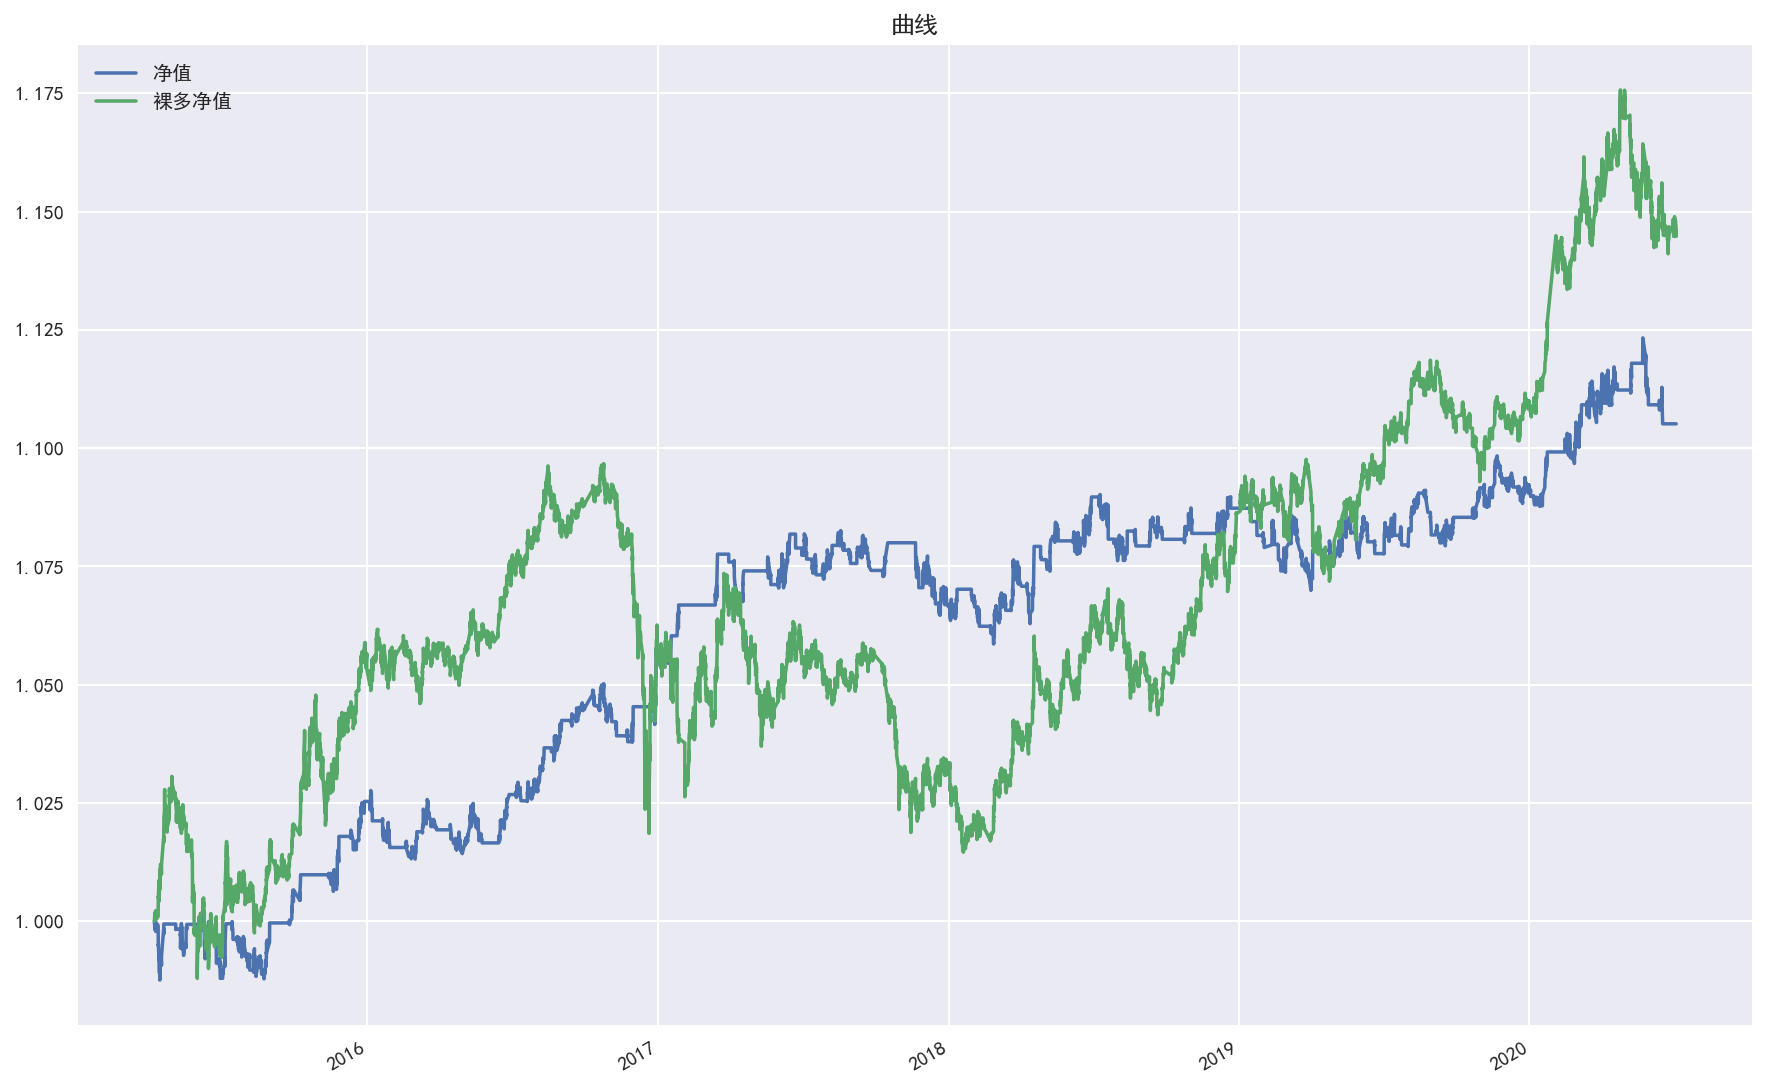

In [402]:
#去掉后面开盘时间修改的数据
future_price=t.copy()
future_price=future_price.iloc[:-2150]
hour=list(future_price.index.hour.values)
minute=list(future_price.index.minute.values)
future_price['time'] = [str(h)+'-'+str(m) for h,m in zip(hour,minute)]
group = pd.DataFrame(np.zeros([len(future_price),1]),index = future_price.index)
group[(future_price['time']=='9-30').values]=1
group[(future_price['time']=='13-15').values]=2
group.columns = ['group']
future_price['group'] = group

future_return = future_price['close'].pct_change()
future_return.name='回报'

#成交量均线
volume_ave = pd.DataFrame(np.zeros([len(future_price),1]),index = future_price.index)
volume_ave[future_price['group']==0]= future_price[future_price['group']==0].rolling(int(20)).mean().iloc[:,4:5]
volume_ave[future_price['group']==1]= future_price[future_price['group']==1].rolling(int(10)).mean().iloc[:,4:5]
volume_ave[future_price['group']==2]= future_price[future_price['group']==2].rolling(int(10)).mean().iloc[:,4:5]
volume_ave = volume_ave.iloc[int(4.5*4*12):].dropna()
volume_ave.columns = ["成交量均线"]

#价格均线
price_ave = pd.DataFrame(future_price['close'].rolling(int(4.5*4*10)).mean())
price_ave.columns =["价格均线"]
std = price_ave.rolling(int(4.5*4*3)).std()
price_vol = pd.DataFrame((1-std/std.max().values[0])*std.max().values[0])##############################
price_vol.columns = ["价格标准差均线"]


#定义趋势项，当均线连续上涨则证明有趋势
price_ave1=future_price['close'].rolling(int(50)).mean()
up_trend = (price_ave1.pct_change()>0).rolling(50).sum()>48
down_trend = (price_ave1.pct_change()<0).rolling(50).sum()>48
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["趋势"]

direction = future_price['close'] - future_price['open']
direction = pd.DataFrame(direction, index =future_price.index,columns=['方向'] )



all_data = pd.concat([future_price[['close','volume']], price_ave,volume_ave,future_return,trend,price_vol,direction ],axis=1).dropna()
#开仓信号，这里的信号定义的是当前时间段收盘时是否应该开仓
signal_data = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)
#记录该时间段内的仓位
position_data1 = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)
bolling = all_data["价格标准差均线"]
price_direction = all_data['方向']

#判断价格是否完成突破
#up_break = all_data.iloc[1:,0].values-all_data.iloc[:-1,2].values-bolling.iloc[:-1]
#up_break=pd.DataFrame(np.append(0,up_break),index = all_data.index)
up_break = all_data['close'] - all_data['价格均线'] - 0.7*bolling
up_break=pd.DataFrame(up_break,index = all_data.index)

up_break_point1 = ((up_break.values[:,0] *np.append(0,up_break[:-1].values))<0)
up_break_point2 = ((up_break.values[:,0] *np.append(np.zeros(2),up_break[:-2].values))<0)
up_break_point3 = ((up_break.values[:,0] *np.append(np.zeros(3),up_break[:-3].values))<0)
up_break_point =  up_break_point1+up_break_point2 #+up_break_point3

#判断价格是否完成突破
#down_break = all_data['close']-all_data['成交量均线'] + bolling
#down_break=pd.DataFrame(np.append(0,down_break),index = all_data.index)
down_break = all_data['close']-all_data['价格均线'] + bolling
down_break=pd.DataFrame(down_break,index = all_data.index)

down_break_point1 = ((down_break.values[:,0]*np.append(0,down_break[:-1].values))<0)
down_break_point2 = ((down_break.values[:,0]*np.append(np.zeros(2),down_break[:-2].values))<0)
down_break_point3 = ((down_break.values[:,0] *np.append(np.zeros(3),down_break[:-3].values))<0)
down_break_point =  down_break_point1+down_break_point2 #+down_break_point3

#判断当期成交量是否够大
volume_break = all_data['volume']/all_data['成交量均线']
volume_break.names = '成交量突破'

#筛除和趋势相反的
tt = all_data['趋势']
up_permit = ~(tt<0).values
down_permit = ~(tt>0).values

#筛除回踩弹回的
up_back = (up_break>0).rolling(4).sum()<3
down_back = (down_break<0).rolling(4).sum()<3

#突破量够大，成交量够大则给出开仓信号############################################
#signal_data[up_permit*(up_back).values[:,0]*up_break_point*(up_break>0).values[:,0]*(volume_break>1.5).values] = 1
#signal_data[down_permit*(down_back).values[:,0]*down_break_point*(down_break<0).values[:,0]*(volume_break>1.5).values]= -1

signal_data[up_permit*(up_back).values[:,0]*up_break_point*(up_break>0).values[:,0]*(volume_break>1.5).values] = 1
signal_data[down_permit*(down_back).values[:,0]*down_break_point*(down_break<0).values[:,0]*(volume_break>1.5).values]= -1


############################################
i =0
open_length = 1000 #假设一般情况下开仓一天
cum_return=0 #记录单次开仓的累计回报，用来止盈/止损
position_number=100 
stop_win = 0.01 #止盈
cut_loss = -0.005 #止损

while i < len(all_data):
        
    if (cum_return>stop_win) or (cum_return<cut_loss):#判断是否需要止盈/止损
        position_number = 1000
        cum_return =0
        
        #当
    if (position_data1.iloc[i-1].values>0) and ( all_data.iloc[i-1,0]< all_data.iloc[i-1,2]):
        position_data1.iloc[i] = 0
        position_number = 1000
        cum_return = 0
    
    if (position_data1.iloc[i-1].values<0) and ( all_data.iloc[i-1,0]> all_data.iloc[i-1,2] ):
        position_data1.iloc[i] =0
        position_number =1000
        cum_return = 0
    
    if position_number<open_length: #判断当天是否需要开仓
        position_data1.iloc[i] = p
        discounted_ratio = p*all_data.iloc[i,5]>0
        position_number = position_number+1
        cum_return = cum_return+all_data['回报'].iloc[i]
    else:
        cum_return=0
        
    if (signal_data.iloc[i]>0).values[0]:        
        p=1
        position_number = 0
        
    if (signal_data.iloc[i]<0).values[0]:
        p=-1
        position_number = 0   
    i=i+1



input_price = pd.DataFrame(all_data["close"])
input_position = position_data1.copy()

new = back_test(input_position, input_price,4*4.5)
new.show_result()
new.result_plot()

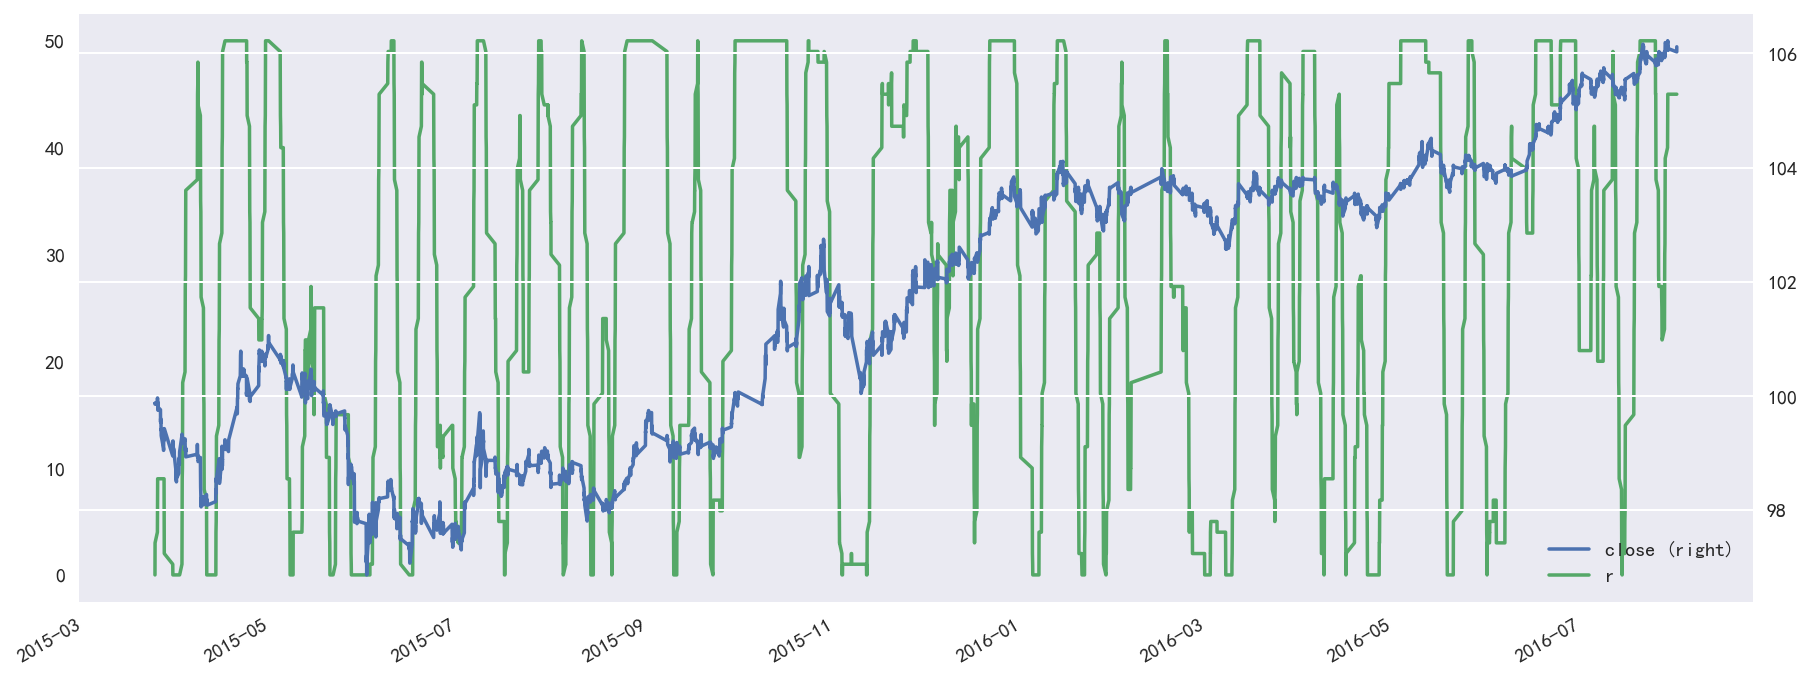

In [327]:
price_ave1=future_price['close'].rolling(int(50)).mean()
tr = (price_ave1.pct_change()>0).rolling(50).sum()
tr.name='r'
pd.concat([future_price['close'],tr],axis=1).dropna().iloc[:6000].plot(figsize=(15,6),secondary_y=['close'])

In [322]:
price_ave1=future_price['close'].rolling(int(50)).mean()
up_trend = (price_ave1.pct_change()>0).rolling(50).sum()>48
down_trend = (price_ave1.pct_change()<0).rolling(50).sum()>48
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["趋势"]

In [366]:
pd.DataFrame(all_data["价格标准差均线"].values,columns=['0'])

,0
0,0.104364
1,0.103369
2,0.102389
3,0.101420
4,0.100446
...,...
22974,0.133780
22975,0.134326
22976,0.134868
22977,0.135402


In [ ]:
pd.DataFrame(all_data["价格标准差均线"]

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        0.0057       |
|  年化波动率  |        0.0129       |
|    夏普比    |        0.4435       |
|   开仓次数   |         191         |
|     胜率     |        0.4503       |
|     赔率     |        1.4605       |
|   做多次数   |          93         |
|   做多胜率   |        0.3226       |
|   做多赔率   |        2.4136       |
|   做空次数   |          98         |
|   做空胜率   |        0.5714       |
|   做空赔率   |        0.938        |
|   最大回撤   |       -0.0258       |
| 回测开始时间 | 2015-04-08 15:15:00 |
| 回测结束时间 | 2020-07-03 13:15:00 |
+--------------+---------------------+


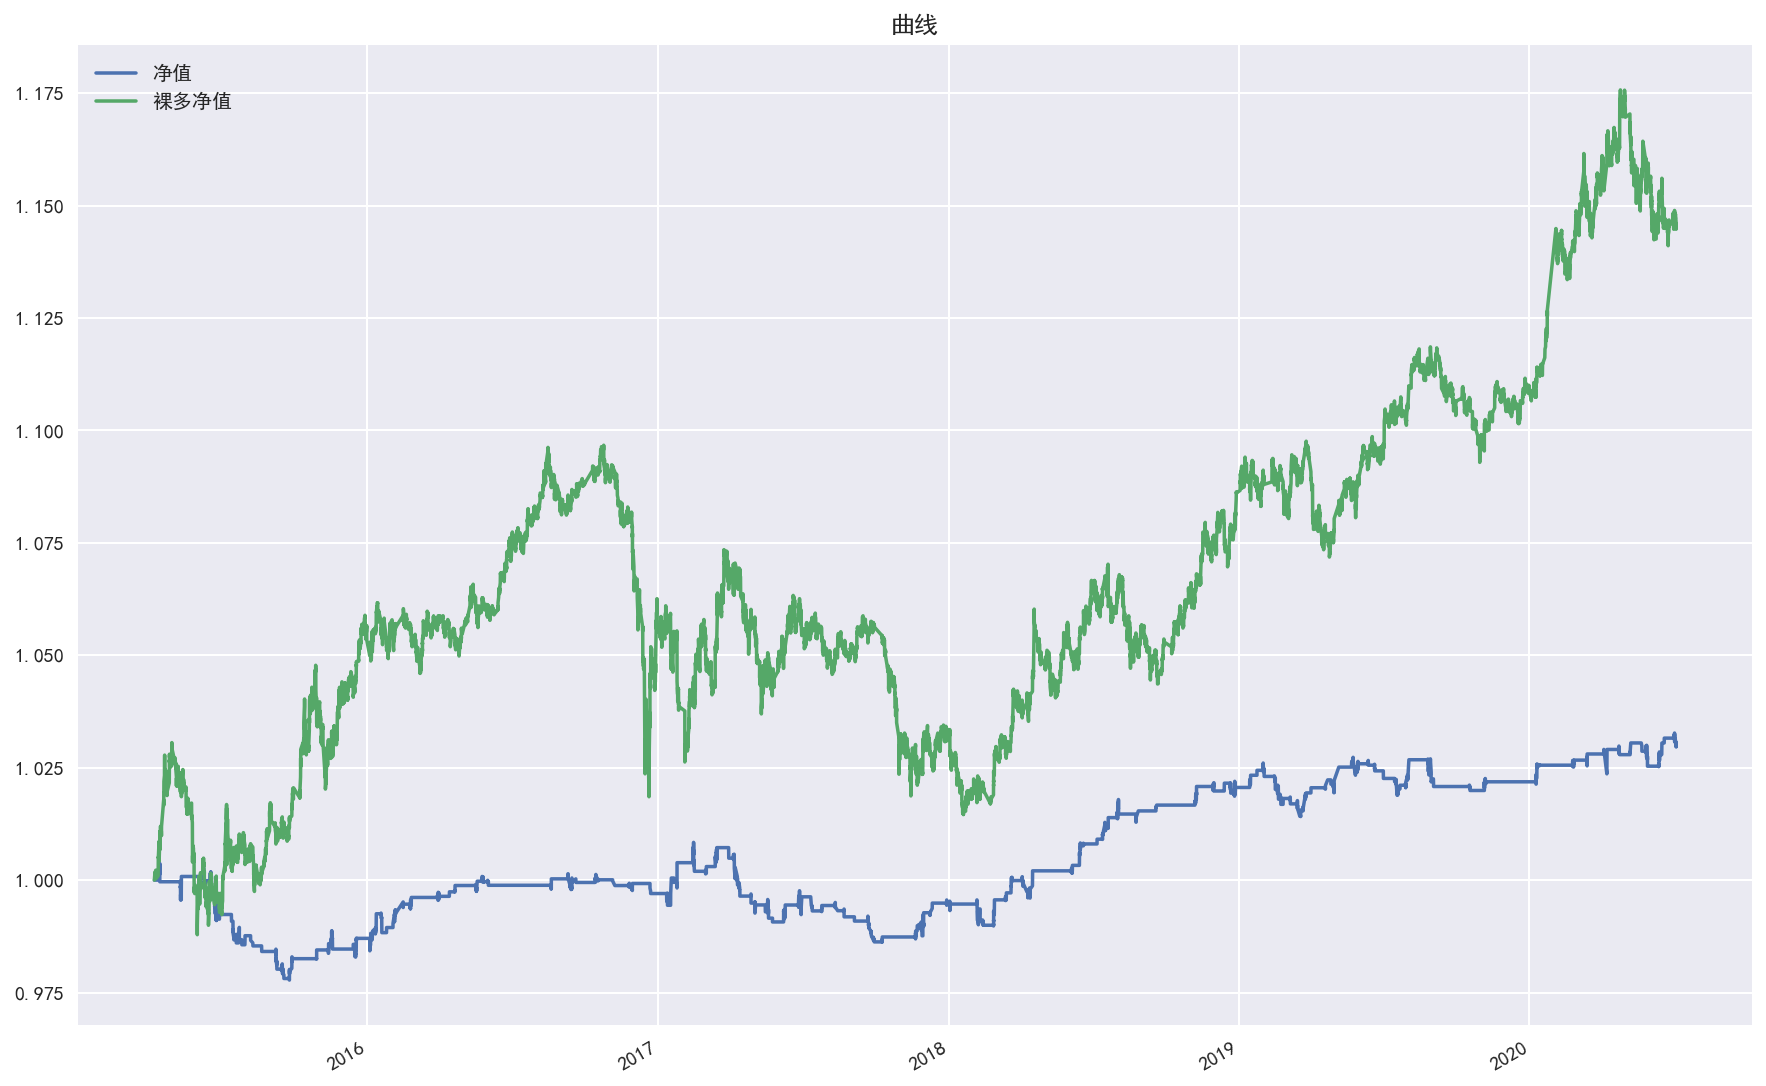

In [386]:
#去掉后面开盘时间修改的数据
future_price=t.copy()
future_price=future_price.iloc[:-2150]
hour=list(future_price.index.hour.values)
minute=list(future_price.index.minute.values)
future_price['time'] = [str(h)+'-'+str(m) for h,m in zip(hour,minute)]
group = pd.DataFrame(np.zeros([len(future_price),1]),index = future_price.index)
group[(future_price['time']=='9-30').values]=1
group[(future_price['time']=='13-15').values]=2
group.columns = ['group']
future_price['group'] = group

future_return = future_price['close'].pct_change()
future_return.name='回报'

#成交量均线
volume_ave = pd.DataFrame(np.zeros([len(future_price),1]),index = future_price.index)
volume_ave[future_price['group']==0]= future_price[future_price['group']==0].rolling(int(20)).mean().iloc[:,4:5]
volume_ave[future_price['group']==1]= future_price[future_price['group']==1].rolling(int(10)).mean().iloc[:,4:5]
volume_ave[future_price['group']==2]= future_price[future_price['group']==2].rolling(int(10)).mean().iloc[:,4:5]
volume_ave = volume_ave.iloc[int(4.5*4*12):].dropna()
volume_ave.columns = ["成交量均线"]

#价格均线  #######################################
price_ave = pd.DataFrame(future_price['close'].rolling(int(4.5*4*10)).mean())
price_ave.columns =["价格均线"]
std = price_ave.rolling(int(4.5*4*3)).std()
price_vol = pd.DataFrame((1-std/std.max().values[0])*std.max().values[0]*1/4)##############################
price_vol.columns = ["价格标准差均线"]


#定义趋势项，当均线连续上涨则证明有趋势
price_ave1=future_price['close'].rolling(int(50)).mean()
up_trend = (price_ave1.pct_change()>0).rolling(50).sum()>48
down_trend = (price_ave1.pct_change()<0).rolling(50).sum()>48
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["趋势"]


all_data = pd.concat([future_price[['close','volume']], price_ave,volume_ave,future_return,trend,price_vol],axis=1).dropna()
#开仓信号，这里的信号定义的是当前时间段收盘时是否应该开仓
signal_data = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)
#记录该时间段内的仓位
position_data1 = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)



#判断价格是否完成突破
#up_break = all_data.iloc[1:,0].values-all_data.iloc[:-1,2].values-bolling.iloc[:-1]
#up_break=pd.DataFrame(np.append(0,up_break),index = all_data.index)
up_break = all_data['close'] - all_data['价格均线']
up_break=pd.DataFrame(up_break,index = all_data.index)
up_break_point1 = ((up_break.values[:,0] *np.append(0,up_break[:-1].values))<0)
up_break_point2 = ((up_break.values[:,0] *np.append(np.zeros(2),up_break[:-2].values))<0)
up_break_point3 = ((up_break.values[:,0] *np.append(np.zeros(3),up_break[:-3].values))<0)
up_break_point =  up_break_point1+up_break_point2 +up_break_point3

#判断价格是否完成突破
#down_break = all_data['close']-all_data['成交量均线'] + bolling
#down_break=pd.DataFrame(np.append(0,down_break),index = all_data.index)
down_break = all_data['close']-all_data['价格均线']
down_break=pd.DataFrame(down_break,index = all_data.index)
down_break_point1 = ((down_break.values[:,0]*np.append(0,down_break[:-1].values))<0)
down_break_point2 = ((down_break.values[:,0]*np.append(np.zeros(2),down_break[:-2].values))<0)
down_break_point3 = ((down_break.values[:,0] *np.append(np.zeros(3),down_break[:-3].values))<0)
down_break_point =  down_break_point1+down_break_point2 +down_break_point3

#判断当期成交量是否够大
volume_break = all_data['volume']/all_data['成交量均线']
volume_break.names = '成交量突破'

#用标准差判断突破强度
bolling = pd.DataFrame(all_data["价格标准差均线"])

#筛除和趋势相反的
tt = all_data['趋势']
up_permit = ~(tt<0).values
down_permit = ~(tt>0).values

#突破量够大，成交量够大则给出开仓信号############################################
signal_data[up_break_point*(up_break.values>bolling.values)[:,0]*(volume_break>1.3).values] = 1
signal_data[down_break_point*(down_break.values<-bolling.values)[:,0]*(volume_break>1.3).values]= -1

############################################
i =0
open_length = 36 #假设一般情况下开仓一天
cum_return=0 #记录单次开仓的累计回报，用来止盈/止损
position_number=100 
stop_win = 0.005 #止盈
cut_loss = -0.001 #止损

while i < len(all_data):
        
    if (cum_return>stop_win) or (cum_return<cut_loss):#判断是否需要止盈/止损
        position_number = 1000
        cum_return =0
        
        #当
    if (position_data1.iloc[i-1].values>0) and ( all_data.iloc[i-1,0]< all_data.iloc[i-1,2]):
        position_data1.iloc[i] = 0
        position_number = 1000
        cum_return = 0
    
    if (position_data1.iloc[i-1].values<0) and ( all_data.iloc[i-1,0]> all_data.iloc[i-1,2] ):
        position_data1.iloc[i] =0
        position_number =1000
        cum_return = 0
    
    if position_number<open_length: #判断当天是否需要开仓
        position_data1.iloc[i] = p
        discounted_ratio = p*all_data.iloc[i,5]>0
        position_number = position_number+1
        cum_return = cum_return+all_data['回报'].iloc[i]
    else:
        cum_return=0
        
    if (signal_data.iloc[i]>0).values[0]:        
        p=1
        position_number = 0
        
    if (signal_data.iloc[i]<0).values[0]:
        p=-1
        position_number = 0   
    i=i+1

input_price = pd.DataFrame(all_data["close"])
input_position = position_data1.copy()

new = back_test(input_position, input_price,4*4.5)
new.show_result()
new.result_plot()

In [380]:
(up_break.values>bolling.values)[:,0]

array([False, False, False, ..., False, False, False])

In [374]:
bolling

,价格标准差均线
2015-04-08 15:15:00,0.104364
2015-04-09 09:30:00,0.103369
2015-04-09 09:45:00,0.102389
2015-04-09 10:00:00,0.101420
2015-04-09 10:15:00,0.100446
...,...
2020-07-03 10:45:00,0.133780
2020-07-03 11:00:00,0.134326
2020-07-03 11:15:00,0.134868
2020-07-03 11:30:00,0.135402


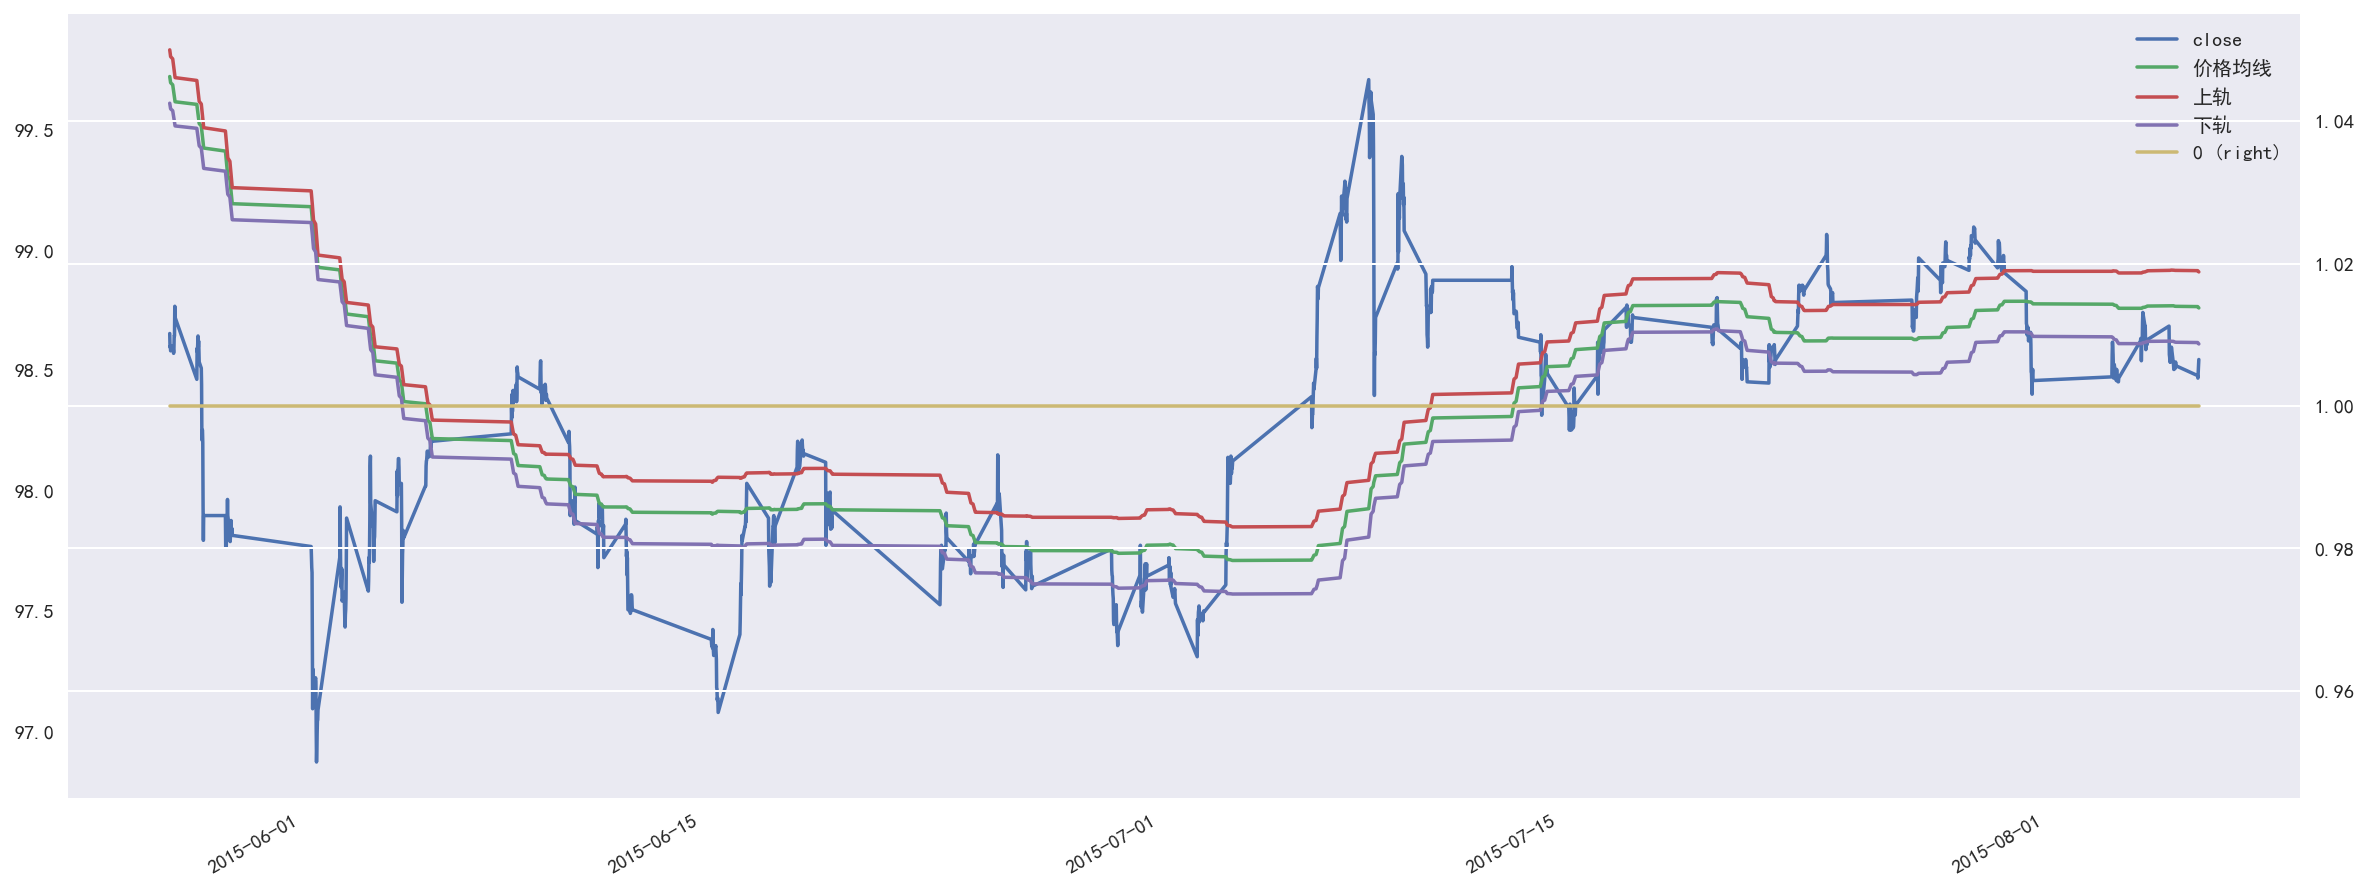

In [357]:
u = all_data['价格均线']+all_data['价格标准差均线']
u= pd.DataFrame(u,columns=['上轨'])
d = all_data['价格均线']-all_data['价格标准差均线']
d= pd.DataFrame(d,columns=['下轨'])
pd.concat([all_data['close'],all_data['价格均线'],u,d,new.net_value,volume_break],axis=1).iloc[600:1500,:-1].plot(figsize=(20,8),secondary_y=[0])

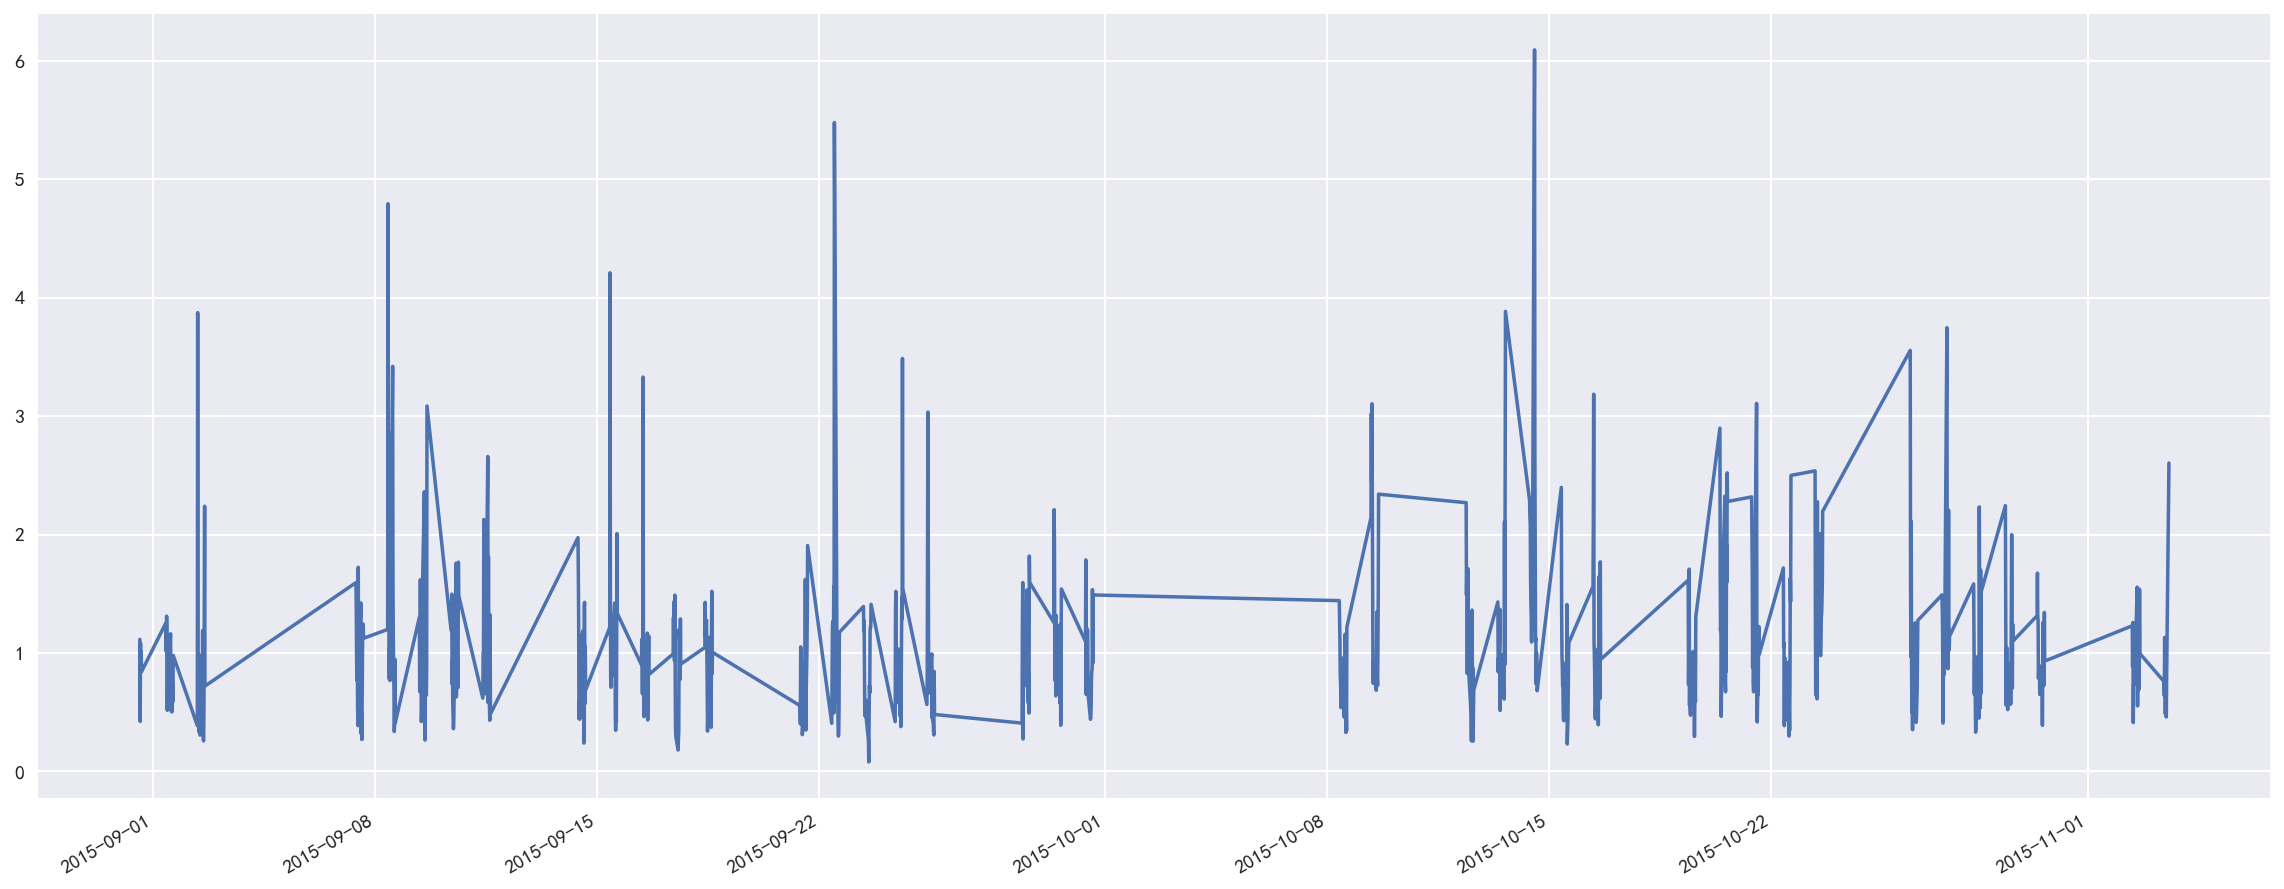

In [205]:
pd.concat([all_data['close'],all_data['价格均线'],u,d,new.net_value,volume_break],axis=1).iloc[1800:2500,-1].plot(figsize=(20,8))

In [759]:
pd.concat([all_data['价格'],all_data['价格均线'],u,d,uu,dd,new.net_value],axis=1).iloc[-1700:]

,价格,价格均线,上轨,下轨,方差上柜,方差下柜,0
2020-08-07 13:30:00,111.144636,111.380867,111.574149,111.187586,111.505393,111.256341,1.118571
2020-08-07 13:45:00,111.077292,111.374601,111.569583,111.179618,111.501328,111.247873,1.118571
2020-08-07 14:00:00,110.993113,111.367399,111.561975,111.172822,111.493599,111.241198,1.118571
2020-08-07 14:15:00,110.892098,111.359978,111.558053,111.161904,111.490757,111.229200,1.118571
2020-08-07 14:30:00,110.914546,111.353151,111.551517,111.154784,111.484315,111.221986,1.118571
...,...,...,...,...,...,...,...
2020-12-25 14:15:00,110.537788,110.228868,110.343806,110.113930,110.272904,110.184833,1.109110
2020-12-25 14:30:00,110.594361,110.231948,110.348588,110.115309,110.277297,110.186599,1.109110
2020-12-25 14:45:00,110.673563,110.235783,110.355935,110.115631,110.283904,110.187661,1.109110
2020-12-25 15:00:00,110.690534,110.239428,110.358669,110.120188,110.286823,110.192034,1.109110


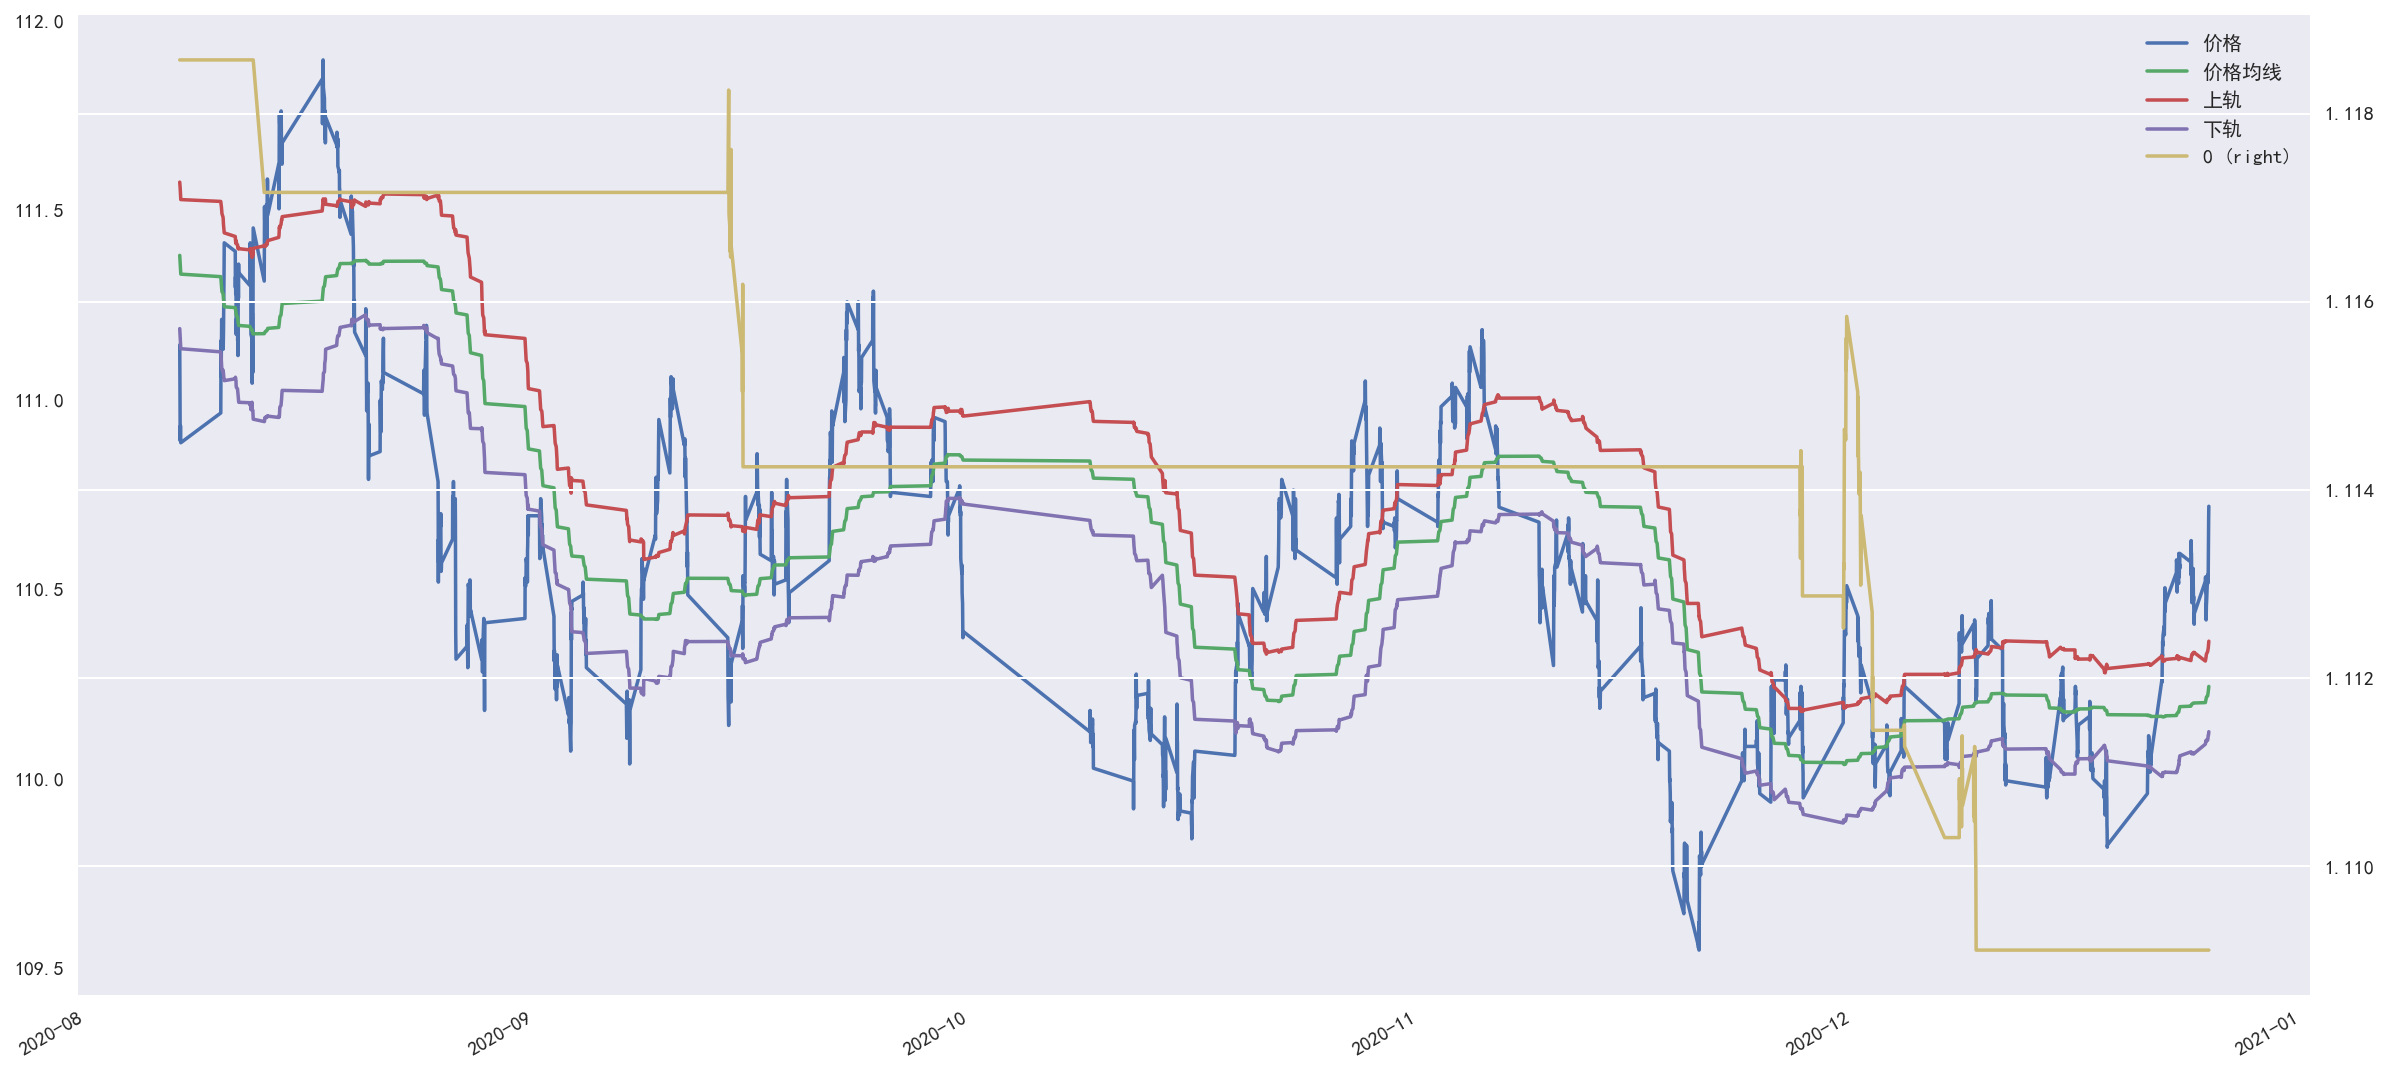

In [750]:
#定义趋势项，当中长期有比较明显的趋势时，增加开仓时间长度
up_trend = future_price1.pct_change(int(4.5*4*10))["价格"]>0.02
down_trend = future_price1.pct_change(int(4.5*4*10))["价格"]<-0.02
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["趋势"]

direction = future_price['close'] - future_price['open']
direction = pd.DataFrame(direction, index =future_price.index,columns=['方向'] )
#价格和成交量的均线
price_ave = pd.DataFrame(future_price1.iloc[:,0].rolling(int(4.5*4*10)).mean())
price_ave.columns =["价格均线"]
volume_ave = pd.DataFrame(future_price1.iloc[:,1].rolling(int(4.5*4*20)).mean())
volume_ave.columns = ["成交量均线"]
price_vol = pd.DataFrame(future_price1.iloc[:,0].diff().rolling(int(4.5*4*3)).std()*3)
price_vol = pd.DataFrame(future_price1.iloc[:,0].diff().rolling(int(4.5*4*3)).var()*30)
price_vol.columns = ["价格标准差均线"]


all_data = pd.concat([future_price1, price_ave,volume_ave,future_return['价格变动'],trend,price_vol,direction ],axis=1).dropna()
#开仓信号，这里的信号定义的是当前时间段收盘时是否应该开仓

u = all_data['价格均线']+all_data['价格标准差均线']
u= pd.DataFrame(u,columns=['上轨'])
d = all_data['价格均线']-all_data['价格标准差均线']
d= pd.DataFrame(d,columns=['下轨'])
pd.concat([all_data['价格'],all_data['价格均线'],u,d,new.net_value],axis=1).iloc[-1700:].plot(figsize=(20,10),secondary_y=[0])

In [139]:
for i in range(1,len(future_price)-36):
    if future_price.index[i]<c:
        morning = 8
        afternoon = 17
    if future_price.index[i]>=c:
        morning = 7
        afternoon = 16
        
    if ((future_price['open'][i] - future_price['close'][i-1])>0.005) and (future_price['open'][i]<future_price['close'][i]) :
        if (future_price['low'][i:i+morning].min()>future_price['high'][i-1]):
            if future_price['open'].pct_change(6)[i+morning]>0:#上午最后15min开盘买入，下午收盘卖出
                long = (future_price['open'].pct_change(60)[i+morning]>0)*1
                long_return.append(future_price['close'][i+afternoon+long*morning]-future_price['open'][i+morning])
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.005) and (future_price['open'][i]>future_price['close'][i]) :
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
            if future_price['open'].pct_change(3)[i+morning]<0:
                short = (future_price['open'].pct_change(60)[i+morning]<0)*1
                short_return.append(future_price['open'][i+morning]-future_price['close'][i+afternoon+short*morning])



AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [415]:
stop_win = 0.01 #止盈
cut_loss = -0.003 #止损
long_return = []
short_return = []
cut=datetime.date(2020, 7, 6)
position_data = pd.DataFrame(np.zeros(len(future_price)),index = future_price.index)
price_data = pd.DataFrame(future_price['close'])

for i in range(1,len(future_price)-36):
    if future_price.index[i]<cut:
        morning = 8
        afternoon = 17
    if future_price.index[i]>=cut:
        morning = 7
        afternoon = 16
        
    if ((future_price['open'][i] - future_price['close'][i-1])>0.01) and (future_price['open'][i]<future_price['close'][i]):
        if (future_price['low'][i:i+morning].min()>future_price['high'][i-1]):
            if future_price['open'].pct_change(6)[i+morning]>0:#上午最后15min开盘买入，下午收盘卖出
                long = (future_price['open'].pct_change(60)[i+morning]>0)*1
                cum_return=0
                for j in range(i+morning,i+afternoon+1+long*morning):
                    if (cum_return>cut_loss) and (cum_return<stop_win):
                        position_data.iloc[j]=1
                        cum_return = future_price['close'][j]/future_price['open'][i+morning]-1
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.01) and (future_price['open'][i]>future_price['close'][i]):
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
            if future_price['open'].pct_change(3)[i+morning]<0:
                short = (future_price['open'].pct_change(60)[i+morning]<0)*1
                cum_return=0
                for j in range(i+morning,i+afternoon+1):
                    if (cum_return>cut_loss) and (cum_return<stop_win):
                        position_data.iloc[j]=-1
                        cum_return = 1-future_price['close'][j]/future_price['open'][i+morning] 

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        0.0149       |
|  年化波动率  |        0.0122       |
|    夏普比    |        1.2208       |
|   开仓次数   |         164         |
|     胜率     |        0.6098       |
|     赔率     |        1.1871       |
|   做多次数   |          89         |
|   做多胜率   |        0.5955       |
|   做多赔率   |        1.0481       |
|   做空次数   |          75         |
|   做空胜率   |        0.6267       |
|   做空赔率   |        1.4579       |
|   最大回撤   |       -0.0141       |
| 回测开始时间 | 2015-03-20 09:45:00 |
| 回测结束时间 | 2020-07-03 13:15:00 |
+--------------+---------------------+


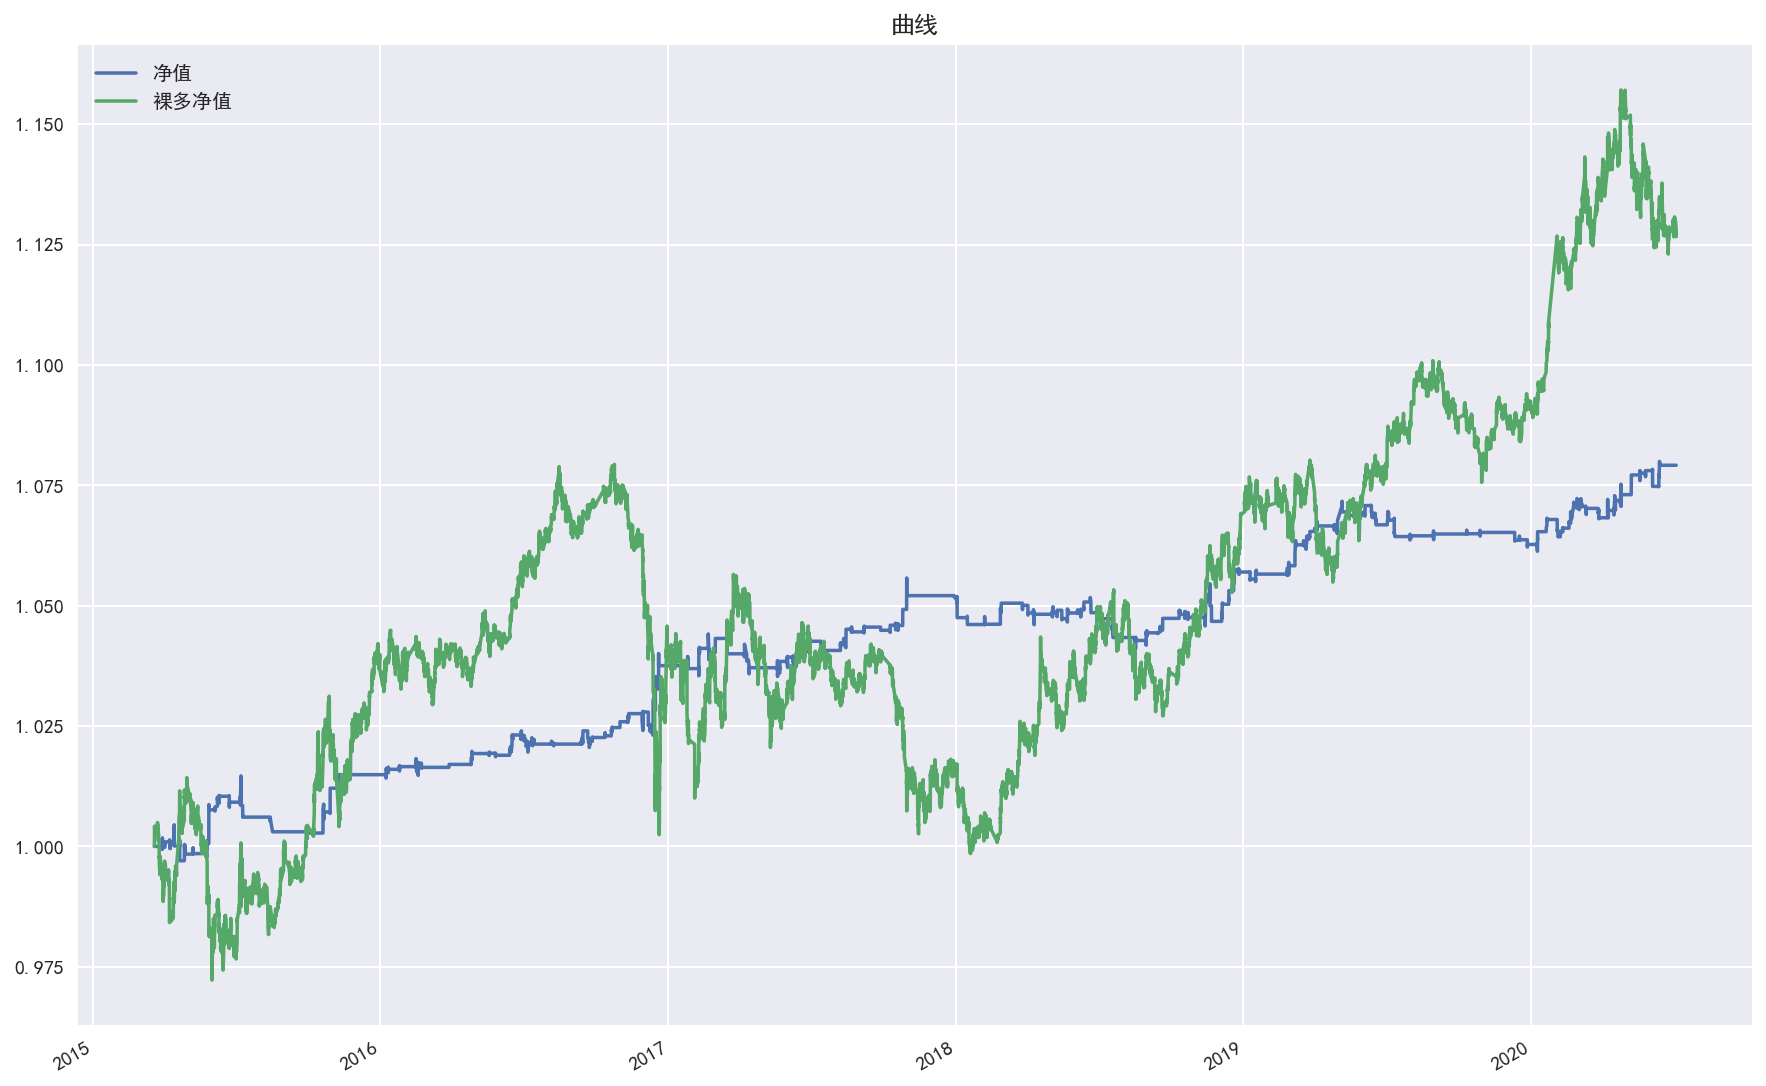

In [416]:
new = back_test(position_data, price_data/100,4*4.5)
new.show_result()
new.result_plot()

In [149]:
len(nnn[(nnn.abs()>0).values])/len(nnn)

NameError: name 'nnn' is not defined

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        0.0221       |
|  年化波动率  |        0.0157       |
|    夏普比    |        1.412        |
|     胜率     |        0.4832       |
|     赔率     |        1.7933       |
|   做多胜率   |        0.5089       |
|   做多赔率   |        1.9131       |
|   做空胜率   |        0.4603       |
|   做空赔率   |        1.7066       |
|   最大回撤   |       -0.0168       |
| 回测开始时间 | 2015-03-20 09:45:00 |
| 回测结束时间 | 2020-12-25 15:15:00 |
+--------------+---------------------+


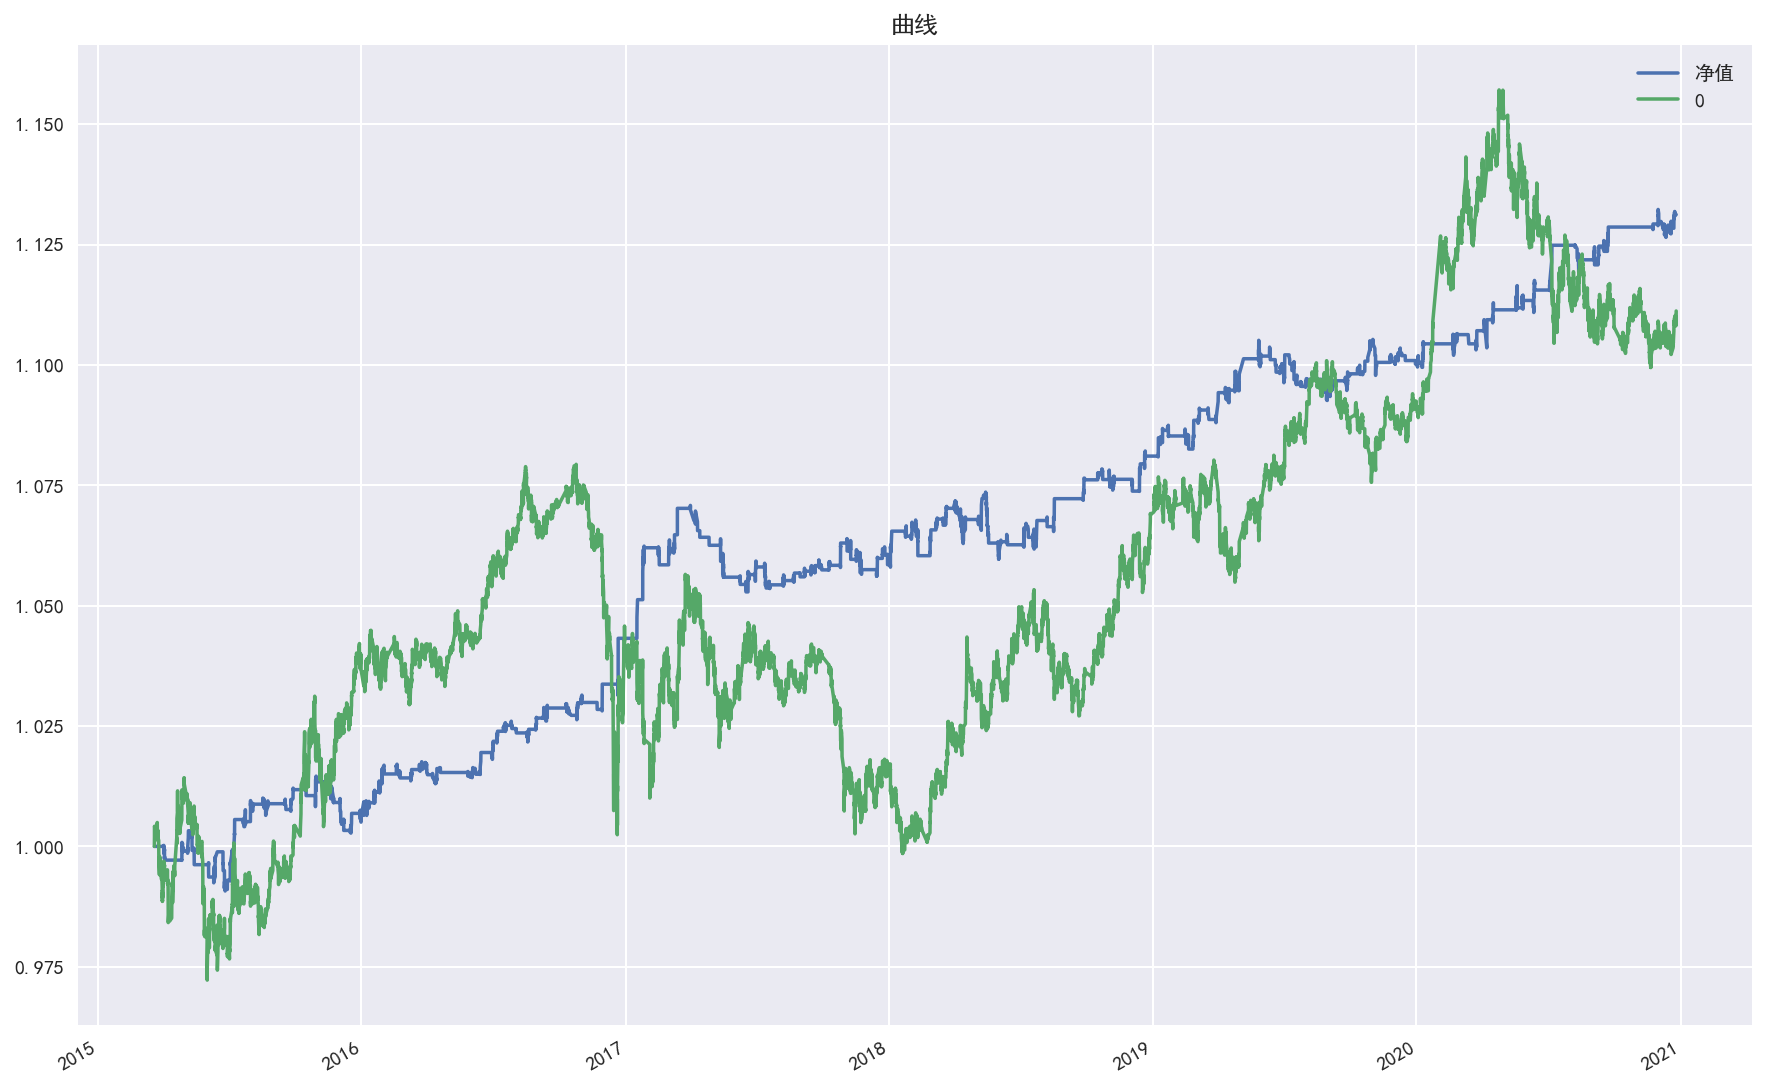

In [230]:
nnn=position_data*10+input_position/input_position.abs()
nnn[~(nnn.abs()>0).values]=0
nnn[(nnn>0).values]=1
nnn[(nnn<0).values]=-1
new11 = back_test(nnn, price_data,4*4.5)
new11.show_result()
new11.result_plot()